# <a name="0.0"></a>Содержание:
* [Описание проекта](#0.)
    - [Описание данных](#0.1.)
* [Шаг 1. Загружаем и подготавливаем данные](#1.)
    - [Загружаем данные](#1.1.)
    - [Ресемплируем данные по 1 часу](#1.2.)
    - [Анализируем данные](#1.3.)
    - [Вывод](#1.4.)
* [Шаг 2. Обучаем разные модели](#2.)
    - [Оценка влияния предыдущих параметров](#2.1.)
    - [Ищем лучшую модель](#2.2.)
    - [Вывод](#2.3.)
* [Шаг 3. Проверяем модель на тестовой выборке](#3.)
    - [Вывод](#3.1.)

<a name="0."></a>
# Описание проекта

На основании исторических данных о заказах такси в аэропортах необходимо спрогнозировать количество заказов такси на следующий час. В качестве метрики используем RMSE

<font size="2">([к содержанию](#0.0))</font>

<a name="0.1."></a>
## Описание данных:

Целевой признак:
- num_orders — количество заказов такси
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="1."></a>
# Шаг 1. Загружаем и подготавливаем данные

<font size="2">([к содержанию](#0.0))</font>

<a name="1.1."></a>
## Загружаем данные

<font size="2">([к содержанию](#0.0))</font>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('./datasets/taxi.csv',
                   index_col=0,
                   parse_dates=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [5]:
data.index.is_monotonic

True

<a name="1.2."></a>
## Ресемплируем данные по 1 часу

<font size="2">([к содержанию](#0.0))</font>

In [6]:
data = data.resample('1H').sum()

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


<a name="1.3."></a>
## Анализируем данные

<font size="2">([к содержанию](#0.0))</font>

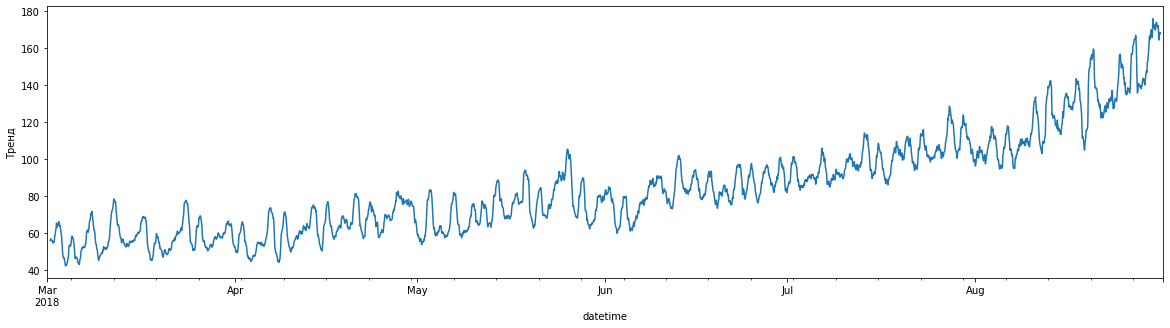

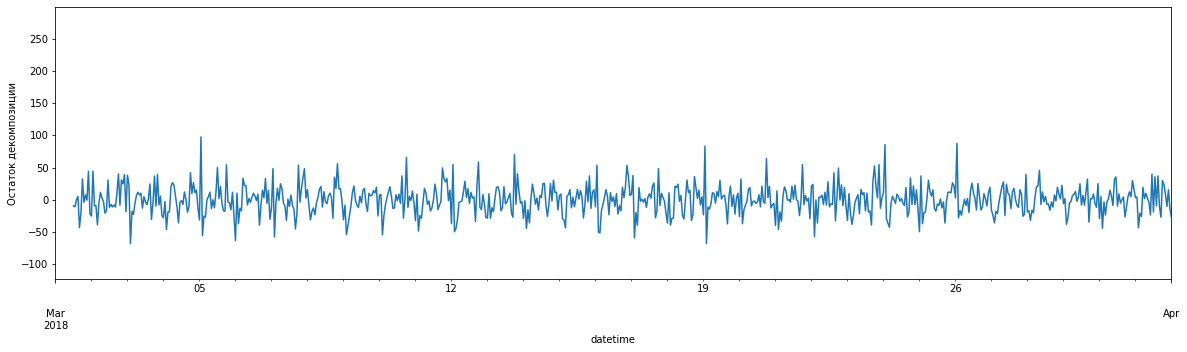

In [8]:
decomposed = seasonal_decompose(data['num_orders'])

start_date = '2018-03'
end_date = '2018-04'

# Тренд
trend = decomposed.trend
trend.plot(figsize=(20,5))
plt.ylabel('Тренд')
plt.show()

# Ошибка
resid = decomposed.resid 
resid.plot(figsize=(20,5), xlim=(start_date, end_date))
plt.ylabel('Остаток декомпозиции')
plt.show()

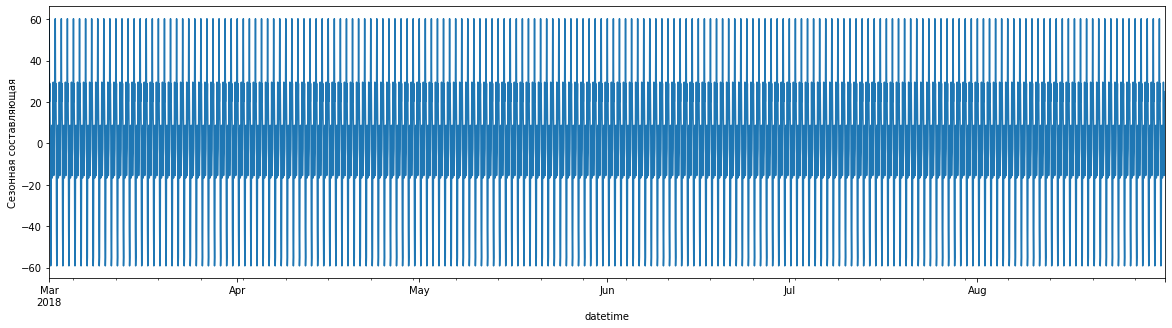

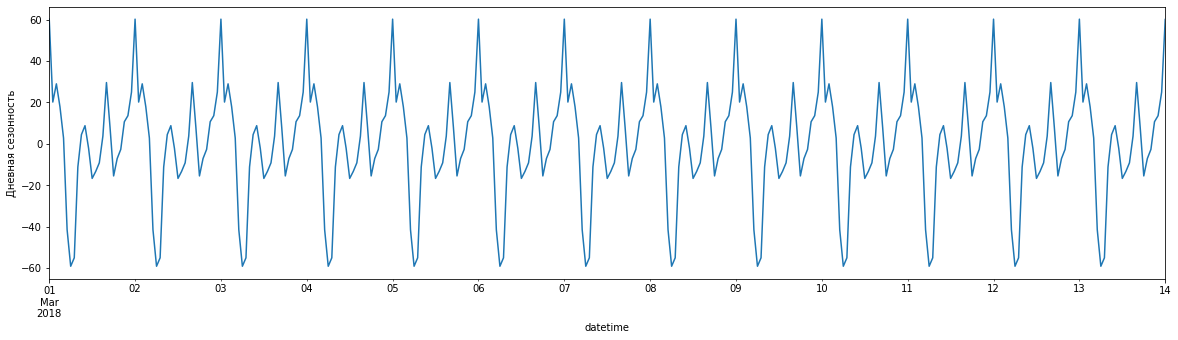

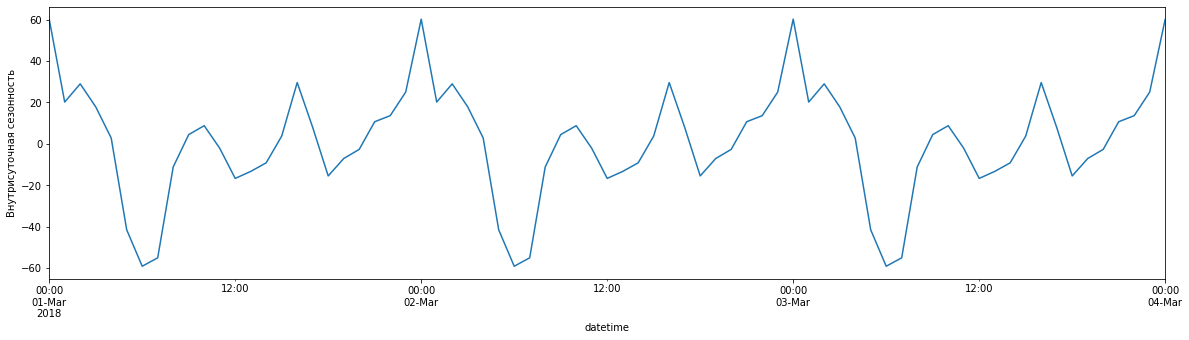

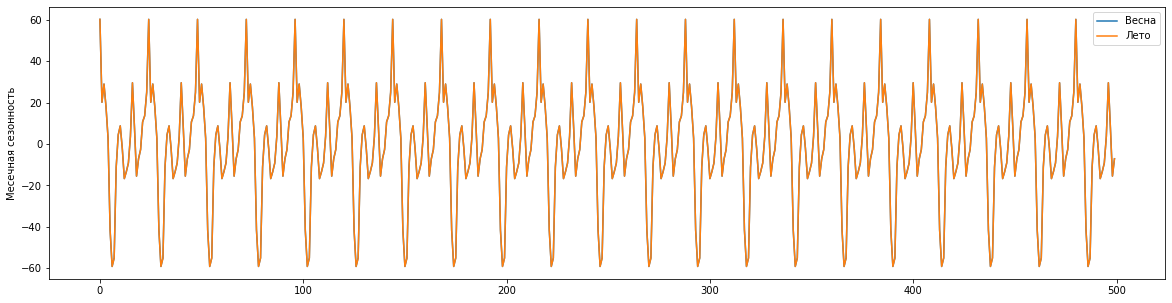

In [9]:
seasonal = decomposed.seasonal
seasonal.plot(figsize=(20,5))
plt.ylabel('Сезонная составляющая')
plt.show()


start_day = '2018-03-01'
end_day = '2018-03-14'
seasonal = decomposed.seasonal
seasonal.plot(figsize=(20,5), xlim=(start_day, end_day))
plt.ylabel('Дневная сезонность')
plt.show()

start_hour = '2018-03-01'
end_hour = '2018-03-04'
seasonal.plot(figsize=(20,5), xlim=(start_hour, end_hour))
plt.ylabel('Внутрисуточная сезонность')
plt.show()

first_seasonal = seasonal[:'2018-03']
second_seasonal = seasonal['2018-08':]
pd.DataFrame({
    'Весна': first_seasonal.values[:500],
    'Лето': second_seasonal.values[:500]
}).plot(figsize=(20,5))
plt.ylabel('Месечная сезонность')
plt.show()

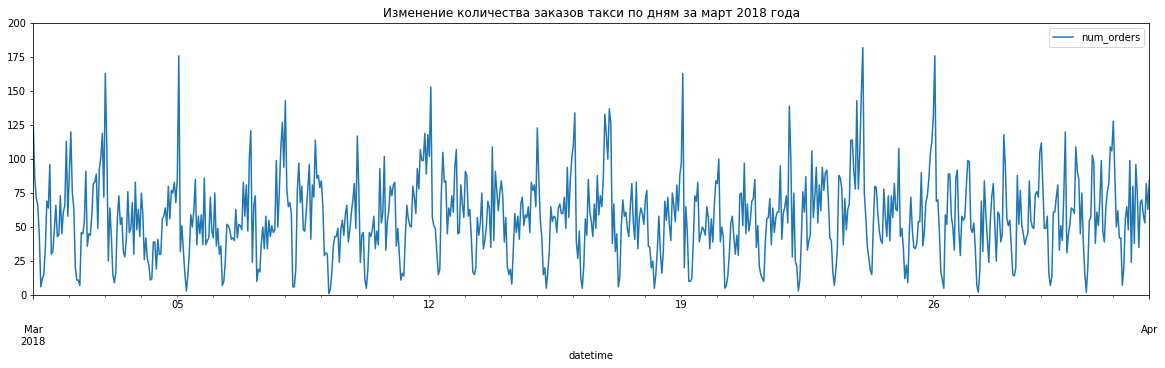

In [10]:
data.plot(figsize=(20,5),
          xlim=(start_date, end_date),
          ylim=(0, 200))
plt.title('Изменение количества заказов такси по дням за март 2018 года')
plt.show()

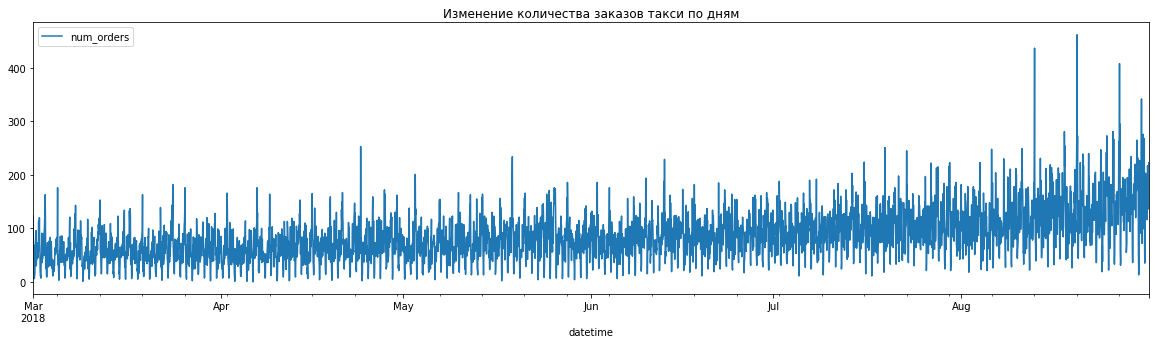

In [11]:
data.plot(figsize=(20,5))
plt.title('Изменение количества заказов такси по дням')
plt.show()

<a name="1.4."></a>
## Вывод

Исходные данные представляют собой таблицу размера 26496х1 без пропусков. Данные расположены в хронологическом порядке с дискретностью в 10 минут. Для ресемплирования данных по 1 часу использовалась функция суммирования, т.е. предполагается, что в исходной таблице num_orders соответствует количеству новых заказов за 10 минут а не количеству аккумилированному количеству клиентов.

Анализ графиков составляющих времененного ряда с помощью разложения его на три составляющих позволяет обнаружить восходящей тренд с явно выраженной внутрисуточной сезонностью, которая повторяется каждый день. Наибольшее число заказов приходится на вечер, а меньше всего заказов после полуночи и ближе к утру. Сезонность по месяцам (весной и летом) и дням (понедельник и пятница) не наблюдается. Рассматриваемый временной ряд относится к числу нестационарных по тренду, потому что у него меняется среднее значение со временем.

На основании того, что имеется восходящий тренд и отсутствует месячная сезонность, можно говорить о росте компании, так как тренд не имеет существенных паданий и наблюдается планомерный рост среднего количества заказов от месяца к месяцу 

<font size="2">([к содержанию](#0.0))</font>

<a name="2."></a>
# Шаг 2. Обучаем разные модели

<font size="2">([к содержанию](#0.0))</font>

<a name="2.1."></a>
## Оценка влияния предыдущих параметров

<font size="2">([к содержанию](#0.0))</font>

In [12]:
def make_features(data, max_lag, rolling_mean_size, goal='num_orders'):
    '''
    Создаём признаки
    '''
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[goal].shift(lag)

    data['rolling_mean'] = data[goal].shift().rolling(rolling_mean_size).mean()

In [13]:
temp = data.copy()
make_features(temp, 5, 5)

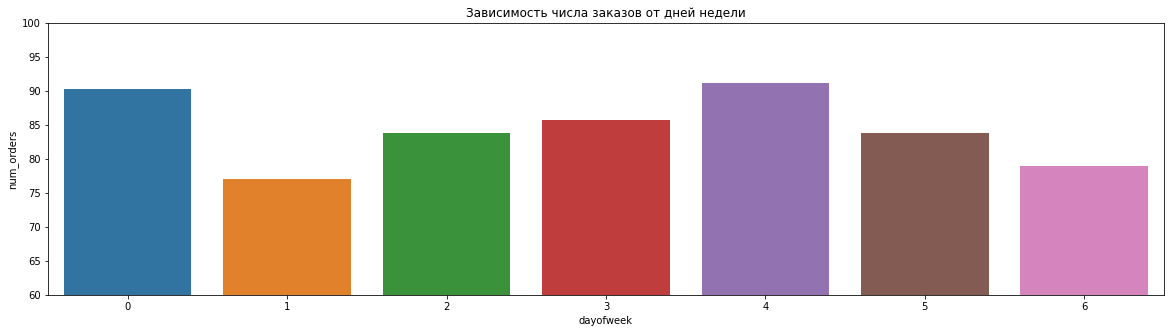

In [14]:
day_pivot = temp.pivot_table(index=['dayofweek'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='dayofweek', y='num_orders',
            data=day_pivot.reset_index())
plt.title('Зависимость числа заказов от дней недели')
plt.ylim(60, 100)
plt.show()

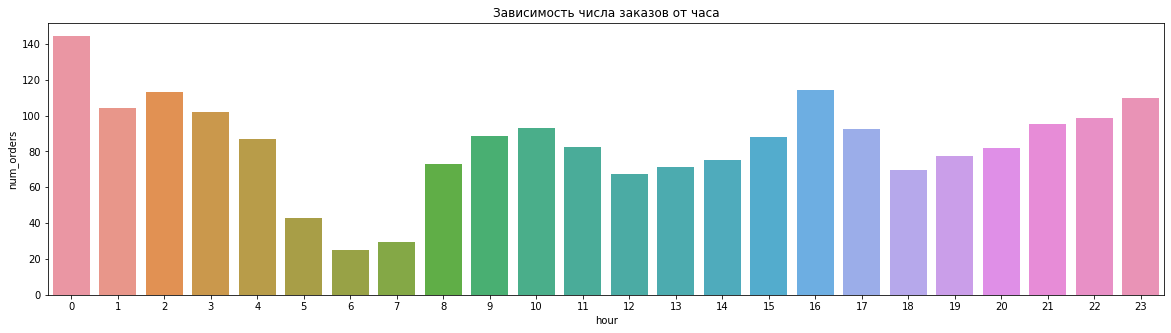

In [15]:
hour_pivot = temp.pivot_table(index=['hour'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='hour', y='num_orders',
            data=hour_pivot.reset_index())
plt.title('Зависимость числа заказов от часа')
plt.show()

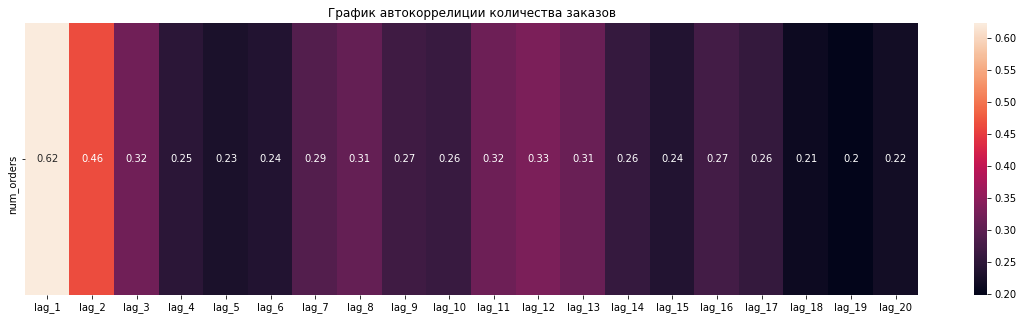

In [16]:
data_for_parse = data.copy()
make_features(data_for_parse, 20, 1)
plt.figure(figsize=(20, 5))
sns.heatmap(
    data_for_parse.drop(['dayofweek', 'hour', 'rolling_mean'], axis=1)
    .dropna().corr()[['num_orders']][1:].T, annot=True)
plt.title('График автокоррелиции количества заказов')
plt.show()

<a name="2.2."></a>
## Ищем лучшую модель

<font size="2">([к содержанию](#0.0))</font>

In [17]:
# Выделяем тестовую выборку
train, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [18]:
def build_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    rmse_valid = mean_squared_error(y_val, model.predict(X_val)) ** 0.5
    return (rmse_train, rmse_valid)

In [19]:
%%time
np.random.seed(1)
stat = pd.DataFrame(columns=['Размер скользящего окна', 
                             'Количество предыдущих значений',
                             'Модель',
                             'RMSE на обучающей',
                             'RMSE на тестовой'])

for i, (window, lag) in enumerate(zip(np.random.randint(5, 30, 10), np.random.randint(5, 30, 10))):
    print(str.center(f'({i+1})', 100, '-'))
    data_for_parse = data.copy()
    
    # Будем работать только с 90% исходной выборки (10 % на тестовый набор)
    data_for_parse, _ = train_test_split(data_for_parse, test_size=0.1, shuffle=False)
    
    # Добавляем признаки и выбрасывае пустые строки
    make_features(data_for_parse, lag, window)
    data_for_parse.dropna(inplace=True)
    
    # Выделяем обучающий и валидационный набор 
    train, valid = train_test_split(data_for_parse, shuffle=False)
    
    # Выделяем признаки и цель
    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    X_val = valid.drop(['num_orders'], axis=1)
    y_val = valid['num_orders']
    
    # Обучаем на линейной регресси
    linear_model = LinearRegression()
    linear_rmse_train, linear_rmse_valid = build_model(linear_model,
                                                       X_train, y_train, 
                                                       X_val, y_val)
    stat.loc[len(stat)] = [window, lag, linear_model,
                           linear_rmse_train, linear_rmse_valid]
    print('Обучили линейную регрессию')
    
    # Обучаем решающее дерево
    tree_model_best = None
    rmse_tree_model_train_best = None
    rmse_tree_model_val_best = None
    for max_depth in np.random.randint(5, 200, 15):
        tree_model = DecisionTreeRegressor(max_depth=max_depth)
        tree_rmse_train, tree_rmse_valid = build_model(tree_model,
                                                       X_train, y_train,
                                                       X_val, y_val)
        if (tree_model_best is None or
            rmse_tree_model_val_best > tree_rmse_valid):
            tree_model_best = tree_model
            rmse_tree_model_train_best = tree_rmse_train
            rmse_tree_model_val_best = tree_rmse_valid
    stat.loc[len(stat)] = [window, lag, tree_model_best, 
                           rmse_tree_model_train_best, rmse_tree_model_val_best]
    print('Обучили решающее дерево')
    
    # Обучаем случайный лес 
    forest_model_best = None
    rmse_forest_model_train_best = None
    rmse_forest_model_val_best = None
    for max_depth, n_estimators in zip(np.random.randint(5, 200, 20),
                                       np.random.randint(5, 30, 20)):
        forest_model = RandomForestRegressor(max_depth=max_depth,
                                         n_estimators=n_estimators)
        forest_rmse_train, forest_rmse_valid = build_model(forest_model,
                                                           X_train, y_train,
                                                           X_val, y_val)
        if (forest_model_best is None or
            rmse_forest_model_val_best > forest_rmse_valid):
            forest_model_best = forest_model
            rmse_forest_model_train_best = forest_rmse_train
            rmse_forest_model_val_best = forest_rmse_valid
    stat.loc[len(stat)] = [window, lag, forest_model_best, 
                           rmse_forest_model_train_best,
                           rmse_forest_model_val_best]
    print('Обучили случайный лес')
    
    # Обучаем градиентным бустингом
    gbmodel = LGBMRegressor()
    
    gb_model_best = None
    rmse_gb_model_train_best = None
    rmse_gb_model_val_best = None
    for max_depth, n_estimators, learning_rate in zip(np.random.randint(5, 200, 20), 
                                                      np.random.randint(5, 30, 20),
                                                      np.random.randint(10, 80, 20),):
        gb_model = LGBMRegressor(max_depth=max_depth,
                                 n_estimators=n_estimators,
                                 learning_rate=learning_rate / 100)
        gb_rmse_train, gb_rmse_valid = build_model(gb_model,
                                                   X_train, y_train,
                                                   X_val, y_val)
        if (gb_model_best is None or
            rmse_gb_model_val_best > gb_rmse_valid):
            gb_model_best = gb_model
            rmse_gb_model_train_best = gb_rmse_train
            rmse_gb_model_val_best = gb_rmse_valid
    stat.loc[len(stat)] = [window, lag, gb_model_best, 
                           rmse_gb_model_train_best,
                           rmse_gb_model_val_best]
    print('Обучили градиентному бустингу')

------------------------------------------------(1)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(2)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(3)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(4)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили градиентному бустингу
------------------------------------------------(5)-------------------------------------------------
Обучили линейную регрессию
Обучили решающее дерево
Обучили случайный лес
Обучили гр

In [20]:
stat.sort_values(by='RMSE на тестовой', ascending=True)

,Размер скользящего окна,Количество предыдущих значений,Модель,RMSE на обучающей,RMSE на тестовой
11,17,12,"LGBMRegressor(learning_rate=0.21, max_depth=14...",14.451527,30.209415
7,16,17,"LGBMRegressor(learning_rate=0.3, max_depth=29,...",12.055458,30.214344
31,20,10,"LGBMRegressor(learning_rate=0.27, max_depth=22...",13.596317,30.390304
15,13,18,"LGBMRegressor(learning_rate=0.4, max_depth=57,...",11.682486,30.423277
10,17,12,"(DecisionTreeRegressor(max_depth=113, max_feat...",8.812833,30.521385
23,16,23,"LGBMRegressor(learning_rate=0.37, max_depth=19...",12.651021,30.653133
35,5,23,"LGBMRegressor(learning_rate=0.25, max_depth=10...",12.606474,30.705481
6,16,17,"(DecisionTreeRegressor(max_depth=161, max_feat...",8.413952,30.710792
18,14,11,"(DecisionTreeRegressor(max_depth=66, max_featu...",8.309876,30.741234
14,13,18,"(DecisionTreeRegressor(max_depth=35, max_featu...",8.178946,30.916123


**Вывод**: для обучения использовались типовые алгоритмы машинного обучения, такие как линейная регрессия решающее дерево, случайный лес и градиентный бустинг. В ходе оубчения исходный набор данных делится на три части обучающий, валидационный и тестовый. Наибольшую точность на валидационном наборе данных показала модель линейной регрессии и модель случайного леса с лагом в 25 часов и окном для скользящего среднего в 10 часов, которую мы и будем использовать для окончательной проверки. 

<a name="2.3."></a>
## Вывод

Для повышения точности моделей машинного обучения на основании исходных данных были добавлены следующие features:
- День недели важен, так как в в пятницу и в понедельник заказов такси в среднем больше чем в остальные дни
- Час временной точки, так как люди чаще заказывают такси утром и вечером с работы когда закрыт общественный транспорт или наоборот (часпик) в метро
- Временного лаг, так как при столь малом временном шаге (1 час) можно предположить, что количество заказов такси в момент t будет примерно равен числу заказов в момент времени t-1. Так из анализа автокорреляции видно, что количество заказов в текущий момент времени умеренно коррелирует с предыдущим часом. Однако для составления прогнозов мы используем большее количество предыдущих точек, так как корреляция с целевой временной точкой у них присутствует и в среднем равна 0.3
- Фактор скользящего окна, так как он помогает сгладить выбросы и чем-то напоминает фактор лага, т.е. он содержит информацию о предыдущих заказах, которые будут примерно похожи на текущий

Для обучения использовались типовые алгоритмы машинного обучения, такие как:
- линейная регрессия
- решающее дерево
- случайный лес
- градиентный бустинг

В ходе обучения исходный набор данных делится на три части: обучающий, валидационный и тестовый наборы данных. Наибольшую точность на валидационном наборе данных показала модель градиентного бустинга с лагом в 12 и с размером скользящего окна равным 17. Именно эта модель и используется на тестовом наборе данных

<font size="2">([к содержанию](#0.0))</font>

<a name="3."></a>
# Шаг 3. Проверяем модель на тестовой выборке

<font size="2">([к содержанию](#0.0))</font>

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [22]:
# Сперва построим базовую модель с прогнозирование на следующий час по предыдущему:
data['num_orders'].shift(1)[1:]
print('RMSE с прогнозированием по предыдущему значению на обучающей:',
      mean_squared_error(train['num_orders'].shift(1)[1:],
                         train['num_orders'][1:])**0.5)
print('RMSE с прогнозированием по предыдущему значению на тестовом:',
      mean_squared_error(test['num_orders'].shift(1)[1:],
                         test['num_orders'][1:])**0.5)

RMSE с прогнозированием по предыдущему значению на обучающей: 36.1452484171318
RMSE с прогнозированием по предыдущему значению на тестовом: 58.91761802963282


In [23]:
# Установим необходимые параметры
data_first_model = data.copy()
make_features(data_first_model, 12, 17)
# Удалим пропуски
data_first_model.dropna(inplace=True)

In [24]:
train, test = train_test_split(data_first_model,
                               shuffle=False,
                               test_size=0.1)
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [25]:
gb_model = stat.loc[11, 'Модель']
gb_model.fit(X_train, y_train)
predict_train = gb_model.predict(X_train)
predict_test = gb_model.predict(X_test)

train_rmse = mean_squared_error(y_train, predict_train)**0.5
test_rmse = mean_squared_error(y_test, predict_test)**0.5

print('Точность градиентного бустинга на обучающем наборе: {:.3f}'.format(train_rmse))
print('Точность градиентного бустинга на тестовом наборе: {:.3f}'.format(test_rmse))

Точность градиентного бустинга на обучающем наборе: 16.862
Точность градиентного бустинга на тестовом наборе: 42.779


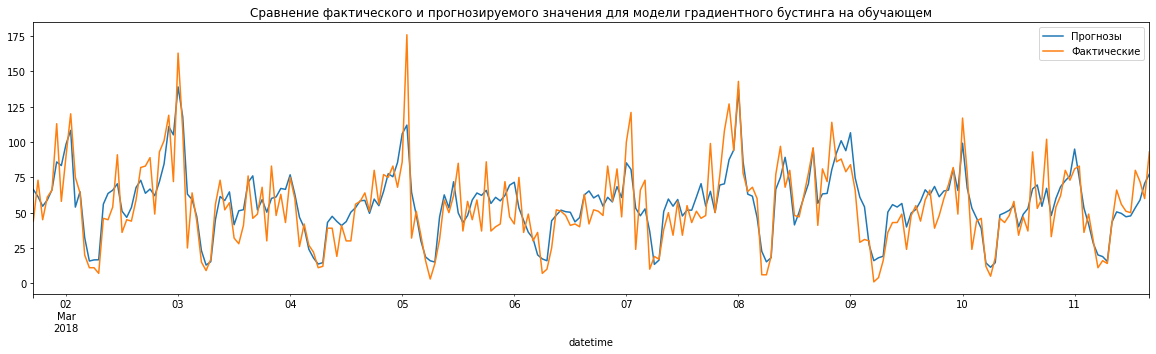

In [26]:
# Прогнозы на 10 дней
pd.DataFrame({'Прогнозы':predict_train,
             'Фактические':y_train})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели градиентного бустинга на обучающем')
plt.show()

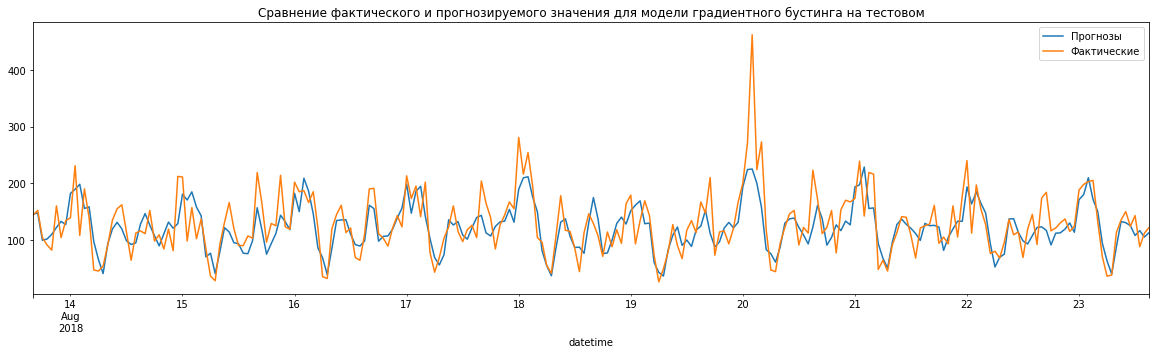

In [27]:
# Прогнозы на 10 дней
pd.DataFrame({'Прогнозы':predict_test,
             'Фактические':y_test})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели градиентного бустинга на тестовом')
plt.show()

In [28]:
forest_model=stat.loc[10,'Модель']
forest_model.fit(X_train, y_train)
predict_train=forest_model.predict(X_train)
predict_test=forest_model.predict(X_test)

train_rmse=mean_squared_error(y_train, predict_train)**0.5
test_rmse=mean_squared_error(y_test, predict_test)**0.5

print('Точность случайного леса на обучающем наборе: {:.3f}'.format(train_rmse))
print('Точность случайного леса на тестовом наборе: {:.3f}'.format(test_rmse))

Точность случайного леса на обучающем наборе: 9.408
Точность случайного леса на тестовом наборе: 44.133


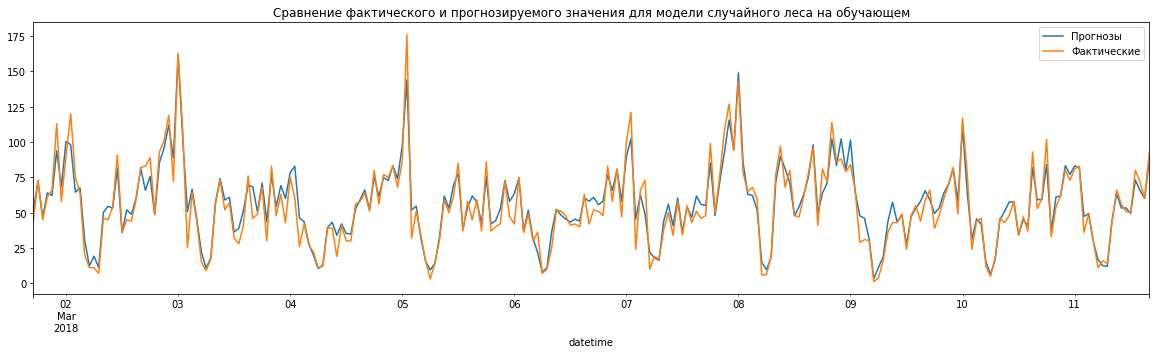

In [29]:
pd.DataFrame({'Прогнозы':predict_train,
             'Фактические':y_train})[:240].plot(figsize=(20, 5))
plt.title('Сравнение фактического и прогнозируемого значения для модели случайного леса на обучающем')
plt.show()

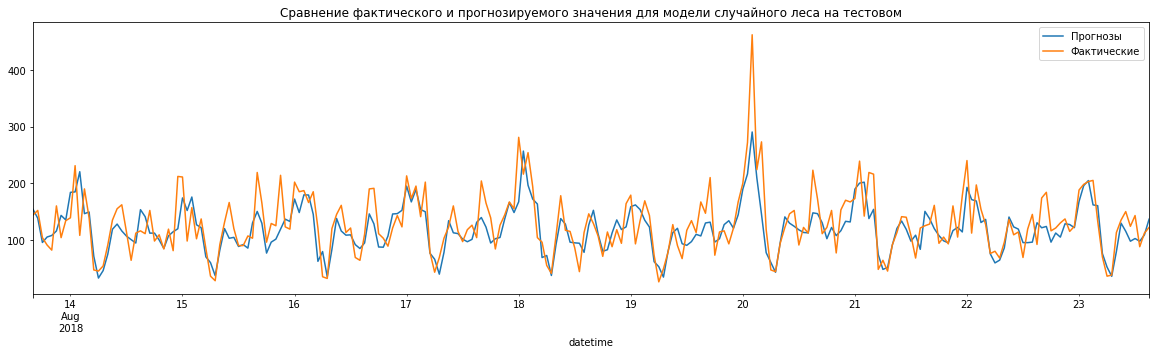

In [30]:
pd.DataFrame({'Прогнозы':predict_test,
             'Фактические':y_test})[:240].plot(figsize=(20, 5))
plt.title('Сравнение фактического и прогнозируемого значения для модели случайного леса на тестовом')
plt.show()

<a name="3.1."></a>
## Вывод

RMSE на тестовом наборе данных примерно равна 48 для модели градиентного спуска, что значительно меньше ошибки, полученной на основании прогнозов по предыдущему значения в исходных данных, равной 58. В качестве альтернативы можно использовать модель решающего дерева, которая даёт также высокую точность прогноза при аналогичном наборе входных параметров.

<font size="2">([к содержанию](#0.0))</font>